Found 4002 images belonging to 4 classes.
Found 998 images belonging to 4 classes.
Detected classes: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Number of classes: 4
Class weights: {0: 1.0898692810457515, 1: 0.9403195488721805, 2: 1.1715456674473068, 3: 0.8580617495711835}
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

===== TRAINING STAGE 1 (Frozen Backbone) =====



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 500ms/step - accuracy: 0.5850 - loss: 1.4524 - val_accuracy: 0.8016 - val_loss: 0.9124 - learning_rate: 3.0000e-04
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 87s 345ms/step - accuracy: 0.8227 - loss: 0.8112 - val_accuracy: 0.8447 - val_loss: 0.8497 - learning_rate: 3.0000e-04
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 86s 342ms/step - accuracy: 0.8535 - loss: 0.7116 - val_accuracy: 0.8417 - val_loss: 0.9103 - learning_rate: 3.0000e-04
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 337ms/step - accuracy: 0.8802 - loss: 0.6219 - val_accuracy: 0.8507 - val_loss: 0.8620 - learning_rate: 3.0000e-04
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 338ms/step - accuracy: 0.8851 - loss: 0.6052 - val_accuracy: 0.8587 - val_loss: 0.8357 - learning_rate: 1.5000e-04
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.8810 - loss: 0.6022 - val_accuracy: 0.8627 - val_loss: 0.8369 - learning_rate: 1.5000e-04
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━

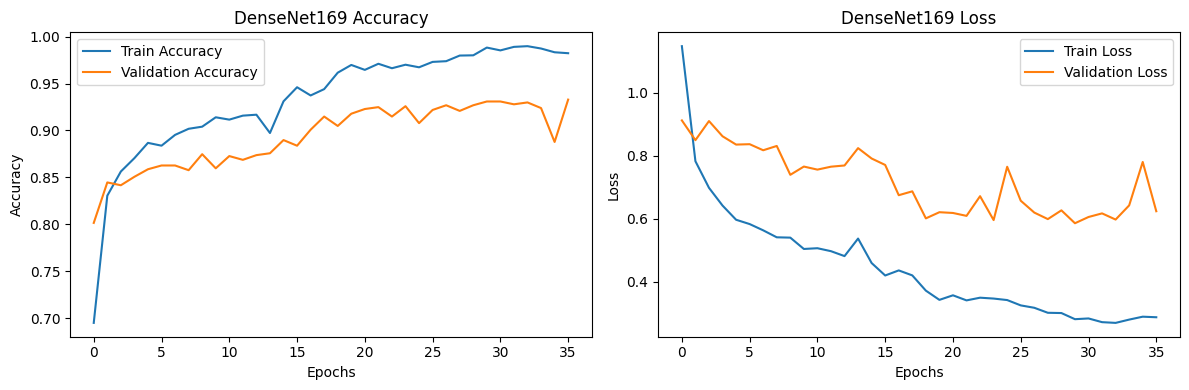

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.9384 - loss: 0.5620

Final Validation Loss: 0.5946
Final Validation Accuracy: 93.29%
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 473ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       229
  meningioma       0.92      0.83      0.87       265
    no_tumor       0.87      0.98      0.92       213
   pituitary       0.95      0.96      0.95       291

    accuracy                           0.93       998
   macro avg       0.93      0.93      0.93       998
weighted avg       0.93      0.93      0.93       998


✅ Accuracy:  93.09%
✅ Precision: 93.08%
✅ Recall:    93.42%
✅ F1-Score:  93.11%


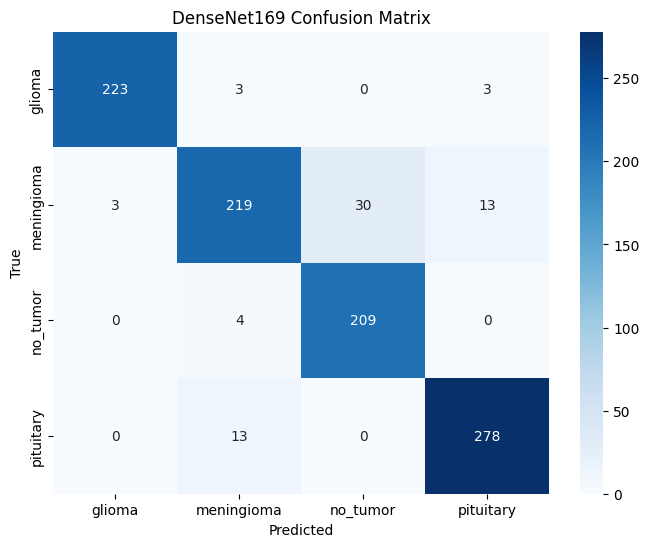

In [3]:
# ============================================================
# IMPORTS
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

# ============================================================
# PATH SETUP
# ============================================================
TRAIN_DIR = "/kaggle/input/brisc2025/brisc2025/classification_task/train"
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Train directory not found: {TRAIN_DIR}")

# ============================================================
# DATA GENERATORS
# ============================================================
batch_size = 16
target_size = (256,256)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.20,
    brightness_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=42
)

num_classes = len(train_generator.class_indices)
print("Detected classes:", train_generator.class_indices)
print("Number of classes:", num_classes)

# ============================================================
# CLASS WEIGHTS
# ============================================================
y_train = train_generator.classes
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

# ============================================================
# BUILD DenseNet169 MODEL
# ============================================================
base_model = DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256, 3)
)

# freeze base for stage 1
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0008))(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0008))(x)
x = Dropout(0.4)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ============================================================
# STAGE 1 TRAINING (Frozen)
# ============================================================
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer_stage1 = Adam(learning_rate=3e-4)

model.compile(
    optimizer=optimizer_stage1,
    loss=loss_fn,
    metrics=['accuracy']
)

early_stop_stage1 = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

reduce_lr_stage1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

print("\n===== TRAINING STAGE 1 (Frozen Backbone) =====\n")
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop_stage1, reduce_lr_stage1],
    class_weight=class_weights,
    verbose=1
)

# ============================================================
# STAGE 2: UNFREEZE + Fine-tune
# ============================================================
# unfreeze last 100 layers of DenseNet169
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

steps_per_epoch = len(train_generator)

cosine_lr = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=3 * steps_per_epoch,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

optimizer_stage2 = Adam(learning_rate=cosine_lr)

model.compile(
    optimizer=optimizer_stage2,
    loss=loss_fn,
    metrics=['accuracy']
)

early_stop_stage2 = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

print("\n===== TRAINING STAGE 2 (Fine-Tuning) =====\n")
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop_stage2],
    class_weight=class_weights,
    verbose=1
)

# ============================================================
# MERGE HISTORIES
# ============================================================
history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
}

# ============================================================
# PLOTS
# ============================================================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet169 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('DenseNet169 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ============================================================
# FINAL EVALUATION
# ============================================================
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nFinal Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# ============================================================
# CLASSIFICATION REPORT
# ============================================================
val_generator.reset()
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes

print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(val_generator.class_indices.keys())
))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n✅ Accuracy:  {acc * 100:.2f}%")
print(f"✅ Precision: {prec * 100:.2f}%")
print(f"✅ Recall:    {rec * 100:.2f}%")
print(f"✅ F1-Score:  {f1 * 100:.2f}%")

# ============================================================
# CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("DenseNet169 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


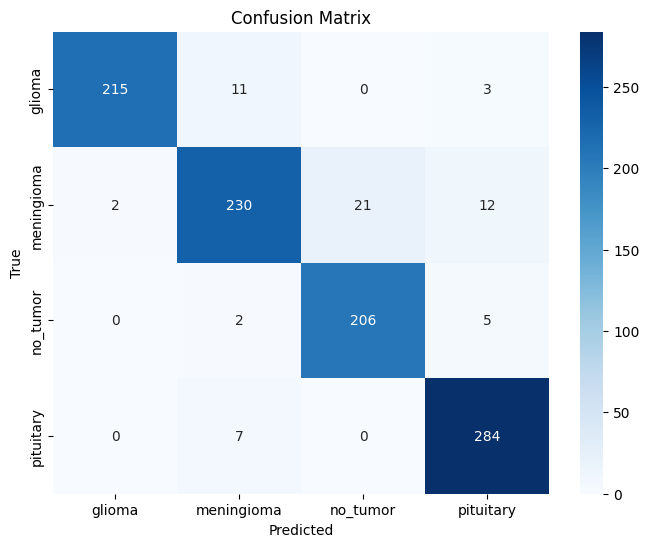

In [2]:
# ============================================================
# CONFUSION MATRIX
# ============================================================
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
